# Atividade 3 - PCA


Entrega: 03/04/2020

ATIVIDADE: trabalhar o dataset nos aspectos:
    - Eliminação (ou não) de instâncias com missing values
    - Normalização
    - Balanceamento de classes

Trabalho:
- Objetivo: reduzir a dimensionalidade do dataset de vocês... (achar os componentes principais do dataset e decidir quantos componentes vai usar )

PDF de slides:
- Métodos: função utilizada e parâmetros (R, Matlab, python), se foi necessário algum pré-processamento dos dados, qual matriz utilizou (e se normalizou os dados ou não) e por quê…
– Pode testar mais de uma alternativa para comparar os resultados
- Resultados:
    * mostrar os PCs (coeficientes) e as variâncias acumuladas
    * com base nos resultados, decidir quantos componentes vai usar, explicando o porquê dessa escolha
- Discussão: sua análise crítica dos resultados scripts utilizados (só para postar no Moodle)

In [124]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# normalizacao
from sklearn import preprocessing

# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# PCA
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state=5007

## Import do Dataset

In [125]:
df = pd.read_csv('../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

df.head()

(858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


## Pré-Processamento

In [126]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [127]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
df_processed.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [128]:
# features continuas
continuous_feat = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 
                   'Smokes (years)', 'Smokes (packs/year)','Hormonal Contraceptives (years)',
                   'IUD (years)', 'STDs (number)','STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

# preenche com a mediana
for cont_col in continuous_feat:
    df_processed[cont_col] = df_processed[cont_col].fillna(df_processed[cont_col].median())
    
    
# preenche com o valor mais frequente
df_processed['Smokes'] = df_processed['Smokes'].fillna(0)
df_processed['Hormonal Contraceptives'] = df_processed['Hormonal Contraceptives'].fillna(1)
df_processed['IUD'] = df_processed['IUD'].fillna(0)
df_processed['STDs'] = df_processed['STDs'].fillna(0)

df_processed['STDs:condylomatosis'] = df_processed['STDs:condylomatosis'].fillna(0)
df_processed['STDs:cervical condylomatosis'] = df_processed['STDs:cervical condylomatosis'].fillna(0)
df_processed['STDs:vaginal condylomatosis'] = df_processed['STDs:vaginal condylomatosis'].fillna(0)
df_processed['STDs:vulvo-perineal condylomatosis'] = df_processed['STDs:vulvo-perineal condylomatosis'].fillna(0)
df_processed['STDs:syphilis'] = df_processed['STDs:syphilis'].fillna(0)
df_processed['STDs:pelvic inflammatory disease'] = df_processed['STDs:pelvic inflammatory disease'].fillna(0)
df_processed['STDs:genital herpes'] = df_processed['STDs:genital herpes'].fillna(0)
df_processed['STDs:molluscum contagiosum'] = df_processed['STDs:molluscum contagiosum'].fillna(0)
df_processed['STDs:AIDS'] = df_processed['STDs:AIDS'].fillna(0)
df_processed['STDs:HIV'] = df_processed['STDs:HIV'].fillna(0)
df_processed['STDs:Hepatitis B'] = df_processed['STDs:Hepatitis B'].fillna(0)
df_processed['STDs:HPV'] = df_processed['STDs:HPV'].fillna(0)

In [129]:
# filling NaN values with dummy values for categorical variables.

df_processed = pd.get_dummies(data=df_processed, columns=['Smokes','Hormonal Contraceptives','IUD','STDs',
                                                'Dx:Cancer','Dx:CIN','Dx:HPV','Dx','Hinselmann',
                                                'Citology','Schiller', 'STDs:condylomatosis', 'STDs:cervical condylomatosis',
                                                'STDs:vaginal condylomatosis',  'STDs:vulvo-perineal condylomatosis', 
                                                'STDs:syphilis', 'STDs:pelvic inflammatory disease','STDs:genital herpes',
                                                'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                                                'STDs:HPV'])

In [130]:
df_processed.isnull().sum()

Age                                       0
Number of sexual partners                 0
First sexual intercourse                  0
Num of pregnancies                        0
Smokes (years)                            0
Smokes (packs/year)                       0
Hormonal Contraceptives (years)           0
IUD (years)                               0
STDs (number)                             0
STDs: Number of diagnosis                 0
STDs: Time since first diagnosis          0
STDs: Time since last diagnosis           0
Biopsy                                    0
Smokes_0.0                                0
Smokes_1.0                                0
Hormonal Contraceptives_0.0               0
Hormonal Contraceptives_1.0               0
IUD_0.0                                   0
IUD_1.0                                   0
STDs_0.0                                  0
STDs_1.0                                  0
Dx:Cancer_0                               0
Dx:Cancer_1                     

In [131]:
df_processed.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Biopsy,Smokes_0.0,Smokes_1.0,Hormonal Contraceptives_0.0,Hormonal Contraceptives_1.0,IUD_0.0,IUD_1.0,STDs_0.0,STDs_1.0,Dx:Cancer_0,Dx:Cancer_1,Dx:CIN_0,Dx:CIN_1,Dx:HPV_0,Dx:HPV_1,Dx_0,Dx_1,Hinselmann_0,Hinselmann_1,Citology_0,Citology_1,Schiller_0,Schiller_1,STDs:condylomatosis_0.0,STDs:condylomatosis_1.0,STDs:cervical condylomatosis_0.0,STDs:vaginal condylomatosis_0.0,STDs:vaginal condylomatosis_1.0,STDs:vulvo-perineal condylomatosis_0.0,STDs:vulvo-perineal condylomatosis_1.0,STDs:syphilis_0.0,STDs:syphilis_1.0,STDs:pelvic inflammatory disease_0.0,STDs:pelvic inflammatory disease_1.0,STDs:genital herpes_0.0,STDs:genital herpes_1.0,STDs:molluscum contagiosum_0.0,STDs:molluscum contagiosum_1.0,STDs:AIDS_0.0,STDs:HIV_0.0,STDs:HIV_1.0,STDs:Hepatitis B_0.0,STDs:Hepatitis B_1.0,STDs:HPV_0.0,STDs:HPV_1.0
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0,4.0,3.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
3,52,5.0,16.0,4.0,37.0,37.0,3.0,0.0,0.0,0,4.0,3.0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
4,46,3.0,21.0,4.0,0.0,0.0,15.0,0.0,0.0,0,4.0,3.0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0


In [132]:
# salva dataset
df_processed.to_csv('../data/df_processed_OHE.csv')

## Split em Train e Test

In [133]:
# Utilizando todas as features como preditoras
X = df_processed.drop('Biopsy', axis=1)
y = df_processed['Biopsy']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.25, random_state=random_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((643, 56), (215, 56), (643,), (215,))

## Normalização

A principio vamos testar o MinMax Scaler

In [134]:
# Aplica MinMax no grupo de treino
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

df_normalized = minmax_scale.fit_transform(X_train)

In [135]:
# transforma de volta para dataframe
df_normalized = pd.DataFrame(df_normalized, columns = X_train.columns.tolist())

df_normalized.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Smokes_0.0,Smokes_1.0,Hormonal Contraceptives_0.0,Hormonal Contraceptives_1.0,IUD_0.0,IUD_1.0,STDs_0.0,STDs_1.0,Dx:Cancer_0,Dx:Cancer_1,Dx:CIN_0,Dx:CIN_1,Dx:HPV_0,Dx:HPV_1,Dx_0,Dx_1,Hinselmann_0,Hinselmann_1,Citology_0,Citology_1,Schiller_0,Schiller_1,STDs:condylomatosis_0.0,STDs:condylomatosis_1.0,STDs:cervical condylomatosis_0.0,STDs:vaginal condylomatosis_0.0,STDs:vaginal condylomatosis_1.0,STDs:vulvo-perineal condylomatosis_0.0,STDs:vulvo-perineal condylomatosis_1.0,STDs:syphilis_0.0,STDs:syphilis_1.0,STDs:pelvic inflammatory disease_0.0,STDs:pelvic inflammatory disease_1.0,STDs:genital herpes_0.0,STDs:genital herpes_1.0,STDs:molluscum contagiosum_0.0,STDs:molluscum contagiosum_1.0,STDs:AIDS_0.0,STDs:HIV_0.0,STDs:HIV_1.0,STDs:Hepatitis B_0.0,STDs:Hepatitis B_1.0,STDs:HPV_0.0,STDs:HPV_1.0
0,0.338028,0.037037,0.500000,0.363636,0.000000,0.000000,0.133333,0.000000,0.0,0.0,0.15,0.1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.098592,0.074074,0.318182,0.090909,0.027027,0.002703,0.100000,0.000000,0.0,0.0,0.15,0.1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.253521,0.074074,0.409091,0.090909,0.000000,0.000000,0.002667,0.421053,0.0,0.0,0.15,0.1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.239437,0.037037,0.318182,0.181818,0.000000,0.000000,0.366667,0.000000,0.0,0.0,0.15,0.1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.140845,0.000000,0.409091,0.272727,0.000000,0.000000,0.033333,0.000000,0.0,0.0,0.15,0.1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [136]:
# salva dataset
df_normalized.to_csv('../data/df_OHE_normalized.csv')

## Balanceamento de classes

Vamos aplicar a tecnica de sampling

a partir de amostras, vamos criar novos registros  nosso conjunto de forma que cada amostra represente o target de forma mais equilibrada

Exemplos:

https://elitedatascience.com/imbalanced-classes

In [137]:
# documentacao SMOTETomek: 
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html

cc = SMOTETomek(random_state=random_state)
X_train_res, y_train_res = cc.fit_resample(df_normalized, y_train)

X_train_res.shape, y_train_res.shape

((1208, 56), (1208,))

## Voltando para escala original

In [138]:
X_train_escala_orig = pd.DataFrame(minmax_scale.inverse_transform(X_train_res))
X_train_escala_orig.columns = X_train_res.columns.tolist()

Aumentamos nosso dataset de treino e teste de 643 para 1208

# PCA

## Primeiro faremos com matriz de covariância

In [139]:
pca = PCA()
pca.fit(X_train_escala_orig)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [140]:
print("Matriz Covariância")
print()

matriz_covariancia = pd.DataFrame(pca.get_covariance())

matriz_covariancia.head()

Matriz Covariância



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,67.446093,1.457574,5.835122,5.412886,10.168547,2.898813,13.708001,3.589957,-0.085849,-0.101861,0.393355,0.504128,-0.168660,0.168660,-0.251433,0.251433,-0.970725,0.970725,0.056712,-0.056712,-0.128478,0.128478,0.067086,-0.067086,-0.121021,0.121021,0.035287,-0.035287,0.160010,-0.160010,-0.275560,0.275560,-0.765365,0.765365,-0.003406,0.003406,0.000000e+00,-0.005371,0.005371,-0.003406,0.003406,-0.003259,0.003259,0.000000e+00,0.000000e+00,0.062073,-0.062073,0.000419,-0.000419,0.000000e+00,0.043343,-0.043343,0.006218,-0.006218,-0.010761,0.010761
1,1.457574,2.038084,-0.578385,0.192938,0.891530,0.614141,-0.002141,0.056743,-0.008091,-0.018030,0.135106,0.127971,-0.074069,0.074069,0.069311,-0.069311,-0.029716,0.029716,0.016777,-0.016777,0.007839,-0.007839,0.006173,-0.006173,0.007011,-0.007011,0.011982,-0.011982,0.074055,-0.074055,-0.077914,0.077914,-0.010280,0.010280,0.006844,-0.006844,2.293430e-60,0.002868,-0.002868,0.006844,-0.006844,-0.005928,0.005928,1.751745e-60,-7.136380e-61,0.011112,-0.011112,-0.001253,0.001253,9.806315e-62,-0.011948,0.011948,0.000404,-0.000404,-0.000850,0.000850
2,5.835122,-0.578385,5.700468,-0.197073,-1.361171,-0.793717,-0.280251,-0.032322,0.096931,0.032596,0.027647,0.088260,0.133937,-0.133937,0.000908,-0.000908,-0.014875,0.014875,-0.037604,0.037604,-0.013610,0.013610,0.004063,-0.004063,-0.006982,0.006982,-0.021321,0.021321,0.113612,-0.113612,-0.045587,0.045587,0.001814,-0.001814,-0.050013,0.050013,-2.807309e-61,-0.011708,0.011708,-0.050013,0.050013,0.016962,-0.016962,-2.143277e-61,8.295318e-62,-0.010854,0.010854,0.000792,-0.000792,-9.707283e-63,0.012154,-0.012154,-0.000865,0.000865,-0.003387,0.003387
3,5.412886,0.192938,-0.197073,1.521753,1.463441,0.301671,1.251006,0.388021,-0.072416,-0.026780,0.115930,0.112826,-0.050099,0.050099,-0.054373,0.054373,-0.097409,0.097409,0.020446,-0.020446,-0.007297,0.007297,0.016176,-0.016176,-0.008954,0.008954,0.020712,-0.020712,-0.014032,0.014032,0.032168,-0.032168,-0.082624,0.082624,0.045205,-0.045205,-1.127244e-61,0.000053,-0.000053,0.045205,-0.045205,-0.014701,0.014701,-8.775674e-62,3.733143e-62,0.008021,-0.008021,-0.001363,0.001363,-4.654058e-63,-0.012542,0.012542,0.001122,-0.001122,0.001416,-0.001416
4,10.168547,0.891530,-1.361171,1.463441,21.882212,6.762712,1.839091,1.268572,0.113600,0.109842,0.057513,0.202822,-1.207414,1.207414,0.136333,-0.136333,-0.130788,0.130788,-0.118692,0.118692,0.010139,-0.010139,0.032418,-0.032418,0.009089,-0.009089,0.066162,-0.066162,-0.351590,0.351590,0.127926,-0.127926,-0.274603,0.274603,0.023366,-0.023366,8.334113e-61,-0.022571,0.022571,0.023366,-0.023366,-0.004563,0.004563,6.402995e-61,-2.511708e-61,0.012168,-0.012168,0.001314,-0.001314,3.629111e-62,-0.130736,0.130736,-0.009457,0.009457,-0.006486,0.006486


In [141]:
print("Auto-vetores:")
print()
autovetores = pd.DataFrame(pca.components_)
autovetores.columns = X_train_res.columns.tolist()

autovetores.to_csv('../data/OHE_autovetores.csv')

autovetores.head()

Auto-vetores:



,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Smokes_0.0,Smokes_1.0,Hormonal Contraceptives_0.0,Hormonal Contraceptives_1.0,IUD_0.0,IUD_1.0,STDs_0.0,STDs_1.0,Dx:Cancer_0,Dx:Cancer_1,Dx:CIN_0,Dx:CIN_1,Dx:HPV_0,Dx:HPV_1,Dx_0,Dx_1,Hinselmann_0,Hinselmann_1,Citology_0,Citology_1,Schiller_0,Schiller_1,STDs:condylomatosis_0.0,STDs:condylomatosis_1.0,STDs:cervical condylomatosis_0.0,STDs:vaginal condylomatosis_0.0,STDs:vaginal condylomatosis_1.0,STDs:vulvo-perineal condylomatosis_0.0,STDs:vulvo-perineal condylomatosis_1.0,STDs:syphilis_0.0,STDs:syphilis_1.0,STDs:pelvic inflammatory disease_0.0,STDs:pelvic inflammatory disease_1.0,STDs:genital herpes_0.0,STDs:genital herpes_1.0,STDs:molluscum contagiosum_0.0,STDs:molluscum contagiosum_1.0,STDs:AIDS_0.0,STDs:HIV_0.0,STDs:HIV_1.0,STDs:Hepatitis B_0.0,STDs:Hepatitis B_1.0,STDs:HPV_0.0,STDs:HPV_1.0
0,0.939645,0.021611,0.073582,0.078312,0.200443,0.063588,0.239008,0.052364,-0.001989,-0.001781,0.006136,0.007394,-0.006039,0.006039,-0.005550,0.005550,-0.013788,0.013788,0.001100,-0.001100,-0.001924,0.001924,0.001058,-0.001058,-0.001823,0.001823,0.000786,-0.000786,0.000825,-0.000825,-0.003532,0.003532,-0.012309,0.012309,0.000468,-0.000468,-0.0,-0.000118,0.000118,0.000468,-0.000468,-0.000019,0.000019,-0.0,-0.0,0.000887,-0.000887,0.000017,-0.000017,-0.0,0.000405,-0.000405,0.000054,-0.000054,-0.000173,0.000173
1,-0.188011,0.040642,-0.155515,0.017488,0.908856,0.314435,-0.075734,0.025037,0.006133,0.006142,0.000218,0.005807,-0.054651,0.054651,0.010005,-0.010005,0.003251,-0.003251,-0.006013,0.006013,0.001692,-0.001692,0.000835,-0.000835,0.001546,-0.001546,0.002742,-0.002742,-0.017462,0.017462,0.007761,-0.007761,-0.004302,0.004302,0.001010,-0.001010,0.0,-0.000879,0.000879,0.001010,-0.001010,-0.000354,0.000354,0.0,0.0,0.000073,-0.000073,0.000040,-0.000040,0.0,-0.006390,0.006390,-0.000518,0.000518,-0.000125,0.000125
2,-0.227397,-0.016400,-0.173412,-0.001556,-0.022959,0.079443,0.949650,-0.033608,-0.025623,-0.015366,0.002973,-0.011839,-0.006039,0.006039,-0.050000,0.050000,0.000302,-0.000302,0.014595,-0.014595,-0.003477,0.003477,0.000624,-0.000624,-0.003761,0.003761,0.002776,-0.002776,-0.009394,0.009394,-0.002313,0.002313,-0.021455,0.021455,0.009886,-0.009886,0.0,0.000708,-0.000708,0.009886,-0.009886,0.000572,-0.000572,0.0,0.0,0.000370,-0.000370,0.000142,-0.000142,0.0,0.004094,-0.004094,0.000069,-0.000069,-0.000104,0.000104
3,-0.116834,-0.213328,0.927259,-0.151803,0.155259,0.014145,0.135632,-0.111745,0.019702,0.008760,-0.014289,-0.003695,-0.009238,0.009238,-0.014654,0.014654,0.022377,-0.022377,-0.009324,0.009324,-0.001152,0.001152,0.000110,-0.000110,-0.000347,0.000347,-0.002018,0.002018,0.000869,-0.000869,0.000857,-0.000857,-0.000852,0.000852,-0.007885,0.007885,0.0,-0.002858,0.002858,-0.007885,0.007885,0.004020,-0.004020,0.0,0.0,-0.003595,0.003595,0.000329,-0.000329,0.0,-0.000499,0.000499,-0.000585,0.000585,-0.000744,0.000744
4,0.039954,0.453197,0.052370,-0.096108,-0.196000,0.596984,-0.046052,-0.582699,0.000162,-0.004409,0.116129,0.104324,-0.012577,0.012577,0.003246,-0.003246,0.078277,-0.078277,0.004907,-0.004907,0.001961,-0.001961,0.000049,-0.000049,-0.000889,0.000889,0.004758,-0.004758,0.034292,-0.034292,-0.043073,0.043073,0.026356,-0.026356,0.001026,-0.001026,0.0,0.000558,-0.000558,0.001026,-0.001026,-0.002390,0.002390,0.0,0.0,0.002571,-0.002571,-0.000096,0.000096,0.0,-0.000249,0.000249,-0.001849,0.001849,-0.000759,0.000759


In [142]:
autovalores = pca.explained_variance_.tolist()
variancia = pca.explained_variance_ratio_
variancia_acumulada = np.cumsum(variancia.tolist())

print('\tAuto-valores\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada):
    print(num+1,'\t' + '%0.3f' % autovalores[num] + '\t\t' +'%0.3f' %variancia[num],'\t\t\t'+ '%0.2f' %item)

	Auto-valores	Variância explicada	Variância acumulada

1 	74.504		0.578 			0.58
2 	22.473		0.174 			0.75
3 	15.069		0.117 			0.87
4 	4.855		0.038 			0.91
5 	2.494		0.019 			0.93
6 	2.233		0.017 			0.94
7 	1.841		0.014 			0.96
8 	1.603		0.012 			0.97
9 	1.040		0.008 			0.98
10 	0.857		0.007 			0.99
11 	0.635		0.005 			0.99
12 	0.310		0.002 			0.99
13 	0.207		0.002 			0.99
14 	0.144		0.001 			1.00
15 	0.137		0.001 			1.00
16 	0.119		0.001 			1.00
17 	0.083		0.001 			1.00
18 	0.068		0.001 			1.00
19 	0.060		0.000 			1.00
20 	0.052		0.000 			1.00
21 	0.028		0.000 			1.00
22 	0.015		0.000 			1.00
23 	0.007		0.000 			1.00
24 	0.006		0.000 			1.00
25 	0.005		0.000 			1.00
26 	0.004		0.000 			1.00
27 	0.003		0.000 			1.00
28 	0.003		0.000 			1.00
29 	0.002		0.000 			1.00
30 	0.001		0.000 			1.00
31 	0.000		0.000 			1.00
32 	0.000		0.000 			1.00
33 	0.000		0.000 			1.00
34 	0.000		0.000 			1.00
35 	0.000		0.000 			1.00
36 	0.000		0.000 			1.00
37 	0.000		0.000 			1.00
38 	0.000		0.000 			1.00
3

### Plotando o somatório cumulativo da variação explicada

In [143]:
max_var = []
for num in range(0, len(variancia)):
    if variancia[num] > 0.02: # threshold - queremos variancia mais que 0.02
        max_var.append(num)

best_var = max(max_var)
# +1 porque a tabela acima começa com 1 e nao com 0 
print('{} - {:.3f}'.format(best_var+1,variancia[best_var]))

4 - 0.038


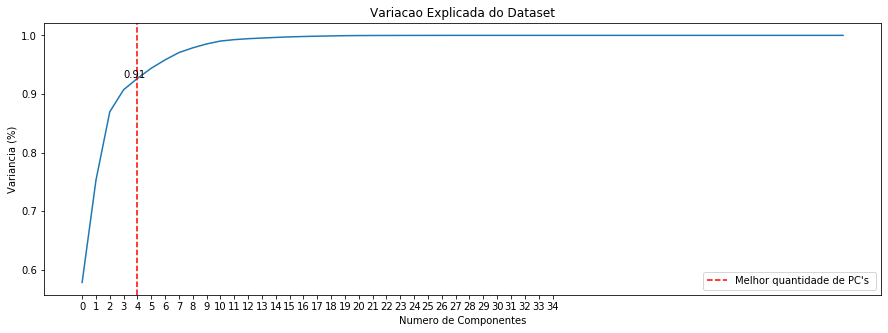

In [144]:
# Plotando o somatório cumulativo da variação explicada
PCA_OHE = plt.figure(figsize=(15,5))
plt.plot(np.cumsum(variancia))
plt.xlabel('Numero de Componentes')
plt.ylabel('Variancia (%)') #for each component
plt.xticks(range(0,35))
plt.axvline(best_var+1, 0, 1, label='Melhor quantidade de PC\'s ',  color='r', linestyle='--')
plt.legend()
plt.title('Variacao Explicada do Dataset')
plt.annotate('{:.2f}'.format(variancia_acumulada[best_var]),
            xy=(best_var, variancia_acumulada[best_var]+0.02), )
plt.show()

PCA_OHE.savefig("PCA_OHE.png", bbox_inches='tight', dpi=600)

10 componentes principais explicam cerca de 93% de toda a variancia dos dados

## Features mais importantes por PC

In [145]:
# https://stackoverflow.com/a/50845697

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE

# numero de features a serem mostradas
n_features = 5
autovetores_copy = autovetores.copy()

# registra o indice das n_features de maior valor absoluto para cada auto vetor
most_important = pd.DataFrame(np.empty((n_pcs, n_features)))                            
for col in range (n_features) :
    nova_coluna = [np.abs(autovetores_copy.iloc[i, :].to_numpy()).argmax() for i in range(n_pcs)]
    most_important.at[:,col] = nova_coluna
    for i in range (n_pcs):
        autovetores_copy.iat[i,nova_coluna[i]] = 0

# armazena nome de cada feature
initial_feature_names = X_train_res.columns.tolist()

# converte os indices armazenados no nome das features correspondentes
most_important_names = pd.DataFrame(np.empty((n_pcs, n_features)))
# get the names
for col in range (n_features):
    most_important_names.at[:,col] = [initial_feature_names[most_important.iloc[i,col]] for i in range(n_pcs)]

In [146]:
importancia_list = pd.DataFrame([['PC{}'.format(i), '%.3f'%variancia[i]]for i in range(n_pcs)])
importancia_list = pd.concat([importancia_list, pd.DataFrame(np.empty((n_pcs, 2 * n_features)))], axis=1)
importancia_list.columns = np.arange(len(importancia_list.columns))

# LIST COMPREHENSION HERE AGAIN
for col in range (n_features):
    new_column = pd.DataFrame([[most_important_names.iloc[i, col], '%.3f'%autovetores.iloc[i, most_important.iloc[i, col]]] for i in range(n_pcs)])
    importancia_list.at[:,2 + col*2] = new_column.iloc[:, 0].tolist()
    importancia_list.at[:,2 + col*2 + 1] = new_column.iloc[:, 1].tolist()

importancia_list.rename(columns={0: 'PCs', 1:'Variância explicada' }, inplace=True)
for col in range(n_features):
    indice_col = 2 + col*2
    importancia_list.rename(columns={indice_col: '{}a Feature mais importante'.format(col + 1), indice_col + 1:'Peso da feature' }, inplace=True)

importancia_list.head(8)

,PCs,Variância explicada,1a Feature mais importante,Peso da feature,2a Feature mais importante,Peso da feature,3a Feature mais importante,Peso da feature,4a Feature mais importante,Peso da feature,5a Feature mais importante,Peso da feature
0,PC0,0.578,Age,0.940,Hormonal Contraceptives (years),0.239,Smokes (years),0.200,Num of pregnancies,0.078,First sexual intercourse,0.074
1,PC1,0.174,Smokes (years),0.909,Smokes (packs/year),0.314,Age,-0.188,First sexual intercourse,-0.156,Hormonal Contraceptives (years),-0.076
2,PC2,0.117,Hormonal Contraceptives (years),0.950,Age,-0.227,First sexual intercourse,-0.173,Smokes (packs/year),0.079,Hormonal Contraceptives_0.0,-0.050
3,PC3,0.038,First sexual intercourse,0.927,Number of sexual partners,-0.213,Smokes (years),0.155,Num of pregnancies,-0.152,Hormonal Contraceptives (years),0.136
4,PC4,0.019,Smokes (packs/year),0.597,IUD (years),-0.583,Number of sexual partners,0.453,Smokes (years),-0.196,STDs: Time since first diagnosis,0.116
5,PC5,0.017,STDs: Time since first diagnosis,0.607,STDs: Time since last diagnosis,0.568,IUD (years),0.464,Number of sexual partners,0.229,First sexual intercourse,0.123
6,PC6,0.014,IUD (years),0.623,Smokes (packs/year),0.458,STDs: Time since first diagnosis,-0.351,STDs: Time since last diagnosis,-0.339,Number of sexual partners,0.262
7,PC7,0.012,Number of sexual partners,0.783,Smokes (packs/year),-0.538,Smokes (years),0.171,First sexual intercourse,0.142,STDs: Time since first diagnosis,-0.126


### Definindo o número de componentes principais

In [147]:
pca_8 = PCA(n_components=8)

X_reduzido = pd.DataFrame(pca_8.fit_transform(X_train_res))

X_reduzido.head()

,0,1,2,3,4,5,6,7
0,-0.849540,-0.271389,0.295321,0.088689,-0.166423,-0.120242,-0.114704,-0.048507
1,-0.748316,0.024175,0.589795,-0.894078,0.674681,-0.152750,0.088730,0.042855
2,-0.759881,-0.453522,0.385188,0.385135,-0.282262,1.395874,1.330274,0.439651
3,-0.846538,-0.284767,0.307973,0.083788,-0.162457,-0.132266,-0.114333,-0.063226
4,-0.855911,-0.260299,0.284888,0.085164,-0.184247,-0.159604,-0.106319,-0.032785


In [148]:
variancia_8 = pca_8.explained_variance_ratio_
variancia_acumulada_8 = np.cumsum(variancia_8.tolist())

print('\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada_8):
    print(num+1,'\t' +'%0.2f' %variancia_8[num],'\t\t\t'+ '%0.2f' %item)

	Variância explicada	Variância acumulada

1 	0.27 			0.27
2 	0.18 			0.45
3 	0.13 			0.58
4 	0.10 			0.68
5 	0.07 			0.76
6 	0.07 			0.82
7 	0.05 			0.87
8 	0.03 			0.91


8 componentes principais explicam cerca de 89% de toda a variancia dos dados

## Testando para matriz de correlação 

Não foi encontrado parâmetro na função que calculasse a matriz de correlação automaticamente, portanto foi calculado o z score

In [149]:
scaler = preprocessing.StandardScaler()

X_std = pd.DataFrame(scaler.fit_transform(X_train_escala_orig))

print('X normalizado com z score')
print()

X_std.describe()

X normalizado com z score



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
count,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1208.0,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1208.0,1208.0,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1208.0,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03,1.208000e+03
mean,-4.058908e-16,-1.558264e-16,-5.201873e-17,-4.204694e-17,-8.003164e-16,-4.639409e-16,4.979461e-16,-2.977750e-17,-1.044051e-15,-4.823221e-16,1.481339e-15,-8.021545e-16,-1.830765e-16,1.749888e-16,-2.803129e-16,2.803129e-16,7.912177e-16,-5.704598e-16,-9.503068e-16,4.951889e-16,3.246116e-16,2.744769e-16,5.491376e-16,-6.733025e-16,2.952017e-16,3.391786e-16,-5.989966e-16,3.364215e-16,2.910843e-15,-2.910843e-15,3.859863e-15,-3.873741e-15,-8.914135e-15,8.443577e-15,-1.113899e-15,8.163540e-16,0.0,1.281708e-15,-6.738654e-16,-1.113899e-15,8.163540e-16,-1.291737e-16,5.029090e-16,0.0,0.0,1.992083e-15,-3.641770e-16,-6.708382e-16,3.104753e-16,0.0,-9.242055e-16,8.227414e-16,-6.737792e-16,3.075343e-16,-7.844167e-16,1.038192e-16
std,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,0.0,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,0.0,0.0,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,0.0,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00,1.000414e+00
min,-1.766996e+00,-1.042053e+00,-2.914695e+00,-1.909605e+00,-3.390761e-01,-2.617764e-01,-6.721000e-01,-2.786341e-01,-3.504409e-01,-3.628858e-01,-2.716514e+00,-2.005532e+00,-2.285735e+00,-4.821819e-01,-6.681470e-01,-1.577910e+00,-3.100928e+00,-3.717149e-01,-2.774302e+00,-3.790430e-01,-5.915370e+00,-1.920884e-01,-7.476006e+00,-1.637756e-01,-5.915370e+00,-1.920884e-01,-5.157800e+00,-2.300755e-01,-1.781900e+00,-6.245331e-01,-2.284808e+00,-5.016947e-01,-1.090332e+00,-9.460979e-01,-3.556034e+00,-2.942570e-01,0.0,-2.004162e+01,-4.989616e-02,-3.556034e+00,-2.942570e-01,-9.983319e+00,-1.001671e-01,0.0,0.0,-1.262030e+01,-1.050075e-01,-3.474191e+01,-2.878368e-02,0.0,-5.630506e+00,-2.094334e-01,-3.474191e+01,-2.878368e-02,-2.455606e+01,-4.072315e-02
25%,-7.924744e-01,-4.333850e-01,-5.828055e-01,-7.677103e-01,-3.390761e-01,-2.617764e-01,-6.721000e-01,-2.786341e-01,-3.504409e-01,-3.628858e-01,1.858147e-02,-7.401896e-02,4.821819e-01,-4.821819e-01,-6.681470e-01,-1.577910e+00,3.717149e-01,-3.717149e-01,3.790430e-01,-3.790430e-01,1.920884e-01,-1.920884e-01,1.637756e-01,-1.637756e-01,1.920884e-01,-1.920884e-01,2.300755e-01,-2.300755e-01,-6.826556e-01,-6.245331e-01,5.016947e-01,-5.016947e-01,-1.090332e+00,-9.460979e-01,2.942570e-01,-2.942570e-01,0.0,4.989616e-02,-4.989616e-02,2.942570e-01,-2.942570e-01,1.001671e-01,-1.001671e-01,0.0,0.0,1.050075e-01,-1.050075e-01,2.878368e-02,-2.878368e-02,0.0,2.094334e-01,-2.094334e-01,2.878368e-02,-2.878368e-02,4.072315e-02,-4.072315e-02
50%,-1.825222e-01,-3.412941e-01,1.837592e-02,-2.876535e-01,-3.390761e-01,-2.617764e-01,-5.438090e-01,-2.786341e-01,-3.504409e-01,-3.628858e-01,1.858147e-02,-7.401896e-02,4.821819e-01,-4.821819e-01,-6.681470e-01,6.681470e-01,3.717149

In [150]:
pca_corr = PCA()
pca_corr.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [151]:
matriz_correlacao = pd.DataFrame(pca_corr.get_covariance())

print("Matriz correlação:")
print()

matriz_correlacao.head()

Matriz correlação:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,1.000829,0.124423,0.297835,0.534734,0.264908,0.168539,0.392833,0.285849,-0.017231,-0.037719,0.043686,0.059308,-0.056868,0.056868,-0.068793,0.068793,-0.410636,0.410636,0.021785,-0.021785,-0.095585,0.095585,0.062433,-0.062433,-0.090038,0.090038,0.023160,-0.023160,0.046905,-0.046905,-0.093535,0.093535,-0.189863,0.189863,-0.001597,0.001597,1.898934e-48,-0.013146,0.013146,-0.001597,0.001597,-0.004003,0.004003,0.000000e+00,0.000000e+00,0.096222,-0.096222,0.001774,-0.001774,0.000000e+00,0.030834,-0.030834,0.026338,-0.026338,-0.032244,0.032244
1,0.124423,1.000829,-0.169828,0.109646,0.133610,0.205408,-0.000353,0.025991,-0.009342,-0.038408,0.086317,0.086606,-0.143668,0.143668,0.109092,-0.109092,-0.072313,0.072313,0.037072,-0.037072,0.033552,-0.033552,0.033048,-0.033048,0.030006,-0.030006,0.045240,-0.045240,0.124881,-0.124881,-0.152140,0.152140,-0.014670,0.014670,0.018466,-0.018466,-1.211061e-46,0.040373,-0.040373,0.018466,-0.018466,-0.041891,0.041891,-1.563892e-63,-1.676503e-63,0.099092,-0.099092,-0.030542,0.030542,1.339942e-63,-0.048897,0.048897,0.009832,-0.009832,-0.014651,0.014651
2,0.297835,-0.169828,1.000829,-0.066967,-0.121975,-0.158734,-0.027625,-0.008852,0.066919,0.041519,0.010561,0.035715,0.155338,-0.155338,0.000855,-0.000855,-0.021644,0.021644,-0.049685,0.049685,-0.034829,0.034829,0.013007,-0.013007,-0.017868,0.017868,-0.048133,0.048133,0.114557,-0.114557,-0.053227,0.053227,0.001547,-0.001547,-0.080686,0.080686,-2.639590e-46,-0.098564,0.098564,-0.080686,0.080686,0.071668,-0.071668,-1.046003e-63,6.146582e-64,-0.057875,0.057875,0.011541,-0.011541,-7.266688e-64,0.029742,-0.029742,-0.012600,0.012600,-0.034904,0.034904
3,0.534734,0.109646,-0.066967,1.000829,0.253815,0.116767,0.238671,0.205688,-0.096763,-0.066020,0.085715,0.088366,-0.112459,0.112459,-0.099041,0.099041,-0.274326,0.274326,0.052287,-0.052287,-0.036143,0.036143,0.100221,-0.100221,-0.044351,0.044351,0.090498,-0.090498,-0.027384,0.027384,0.072693,-0.072693,-0.136453,0.136453,0.141152,-0.141152,4.274377e-46,0.000865,-0.000865,0.141152,-0.141152,-0.120213,0.120213,-2.169446e-64,1.481624e-63,0.082776,-0.082776,-0.038438,0.038438,1.197283e-63,-0.059401,0.059401,0.031649,-0.031649,0.028250,-0.028250
4,0.264908,0.133610,-0.121975,0.253815,1.000829,0.690295,0.092527,0.177336,0.040029,0.071410,0.011214,0.041891,-0.714733,0.714733,0.065487,-0.065487,-0.097132,0.097132,-0.080044,0.080044,0.013243,-0.013243,0.052967,-0.052967,0.011872,-0.011872,0.076236,-0.076236,-0.180944,0.180944,0.076235,-0.076235,-0.119594,0.119594,0.019241,-0.019241,-1.250071e-46,-0.096985,0.096985,0.019241,-0.019241,-0.009841,0.009841,-1.132298e-63,-4.749811e-63,0.033114,-0.033114,0.009768,-0.009768,-1.225355e-63,-0.163281,0.163281,-0.070323,0.070323,-0.034120,0.034120


In [152]:
print("Auto-vetores:")
print()
autovetores_corr = pd.DataFrame(pca_corr.components_)

autovetores_corr.to_csv('../data/OHE_autovetores_correlacao.csv')

autovetores_corr.head()

Auto-vetores:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,-0.005810,0.001682,0.016794,-0.027994,0.044622,0.014881,-0.060931,-0.003503,0.341921,0.327962,-0.007311,0.064714,-0.088770,0.088770,0.070303,-0.070303,0.000565,-0.000565,-0.329655,0.329655,0.050909,-0.050909,0.039292,-0.039292,0.050425,-0.050425,0.060194,-0.060194,-0.043194,0.043194,-0.029606,0.029606,-0.078367,0.078367,-0.314920,0.314920,-4.978412e-60,-0.073906,0.073906,-0.314920,0.314920,-0.065324,0.065324,-0.0,-0.0,-0.023256,0.023256,-0.011806,0.011806,-0.0,-0.177687,0.177687,-0.032810,0.032810,-0.006015,0.006015
1,0.089681,-0.012615,0.026553,0.036603,0.014711,0.021717,0.083089,0.086429,0.039996,0.034363,0.061985,0.074327,0.021884,-0.021884,-0.063715,0.063715,-0.113327,0.113327,-0.041993,0.041993,-0.389310,0.389310,-0.084184,0.084184,-0.383637,0.383637,-0.311256,0.311256,-0.105826,0.105826,-0.078128,0.078128,-0.134656,0.134656,-0.033333,0.033333,-0.000000e+00,0.004930,-0.004930,-0.033333,0.033333,0.009506,-0.009506,-0.0,-0.0,0.017169,-0.017169,0.011308,-0.011308,-0.0,-0.021056,0.021056,-0.013262,0.013262,-0.143551,0.143551
2,-0.192283,-0.076992,0.060491,-0.194252,-0.235022,-0.194548,-0.196710,-0.121880,0.060198,0.059639,-0.022251,-0.018670,0.171590,-0.171590,0.076532,-0.076532,0.148561,-0.148561,-0.061411,0.061411,-0.038909,0.038909,-0.238698,0.238698,-0.037811,0.037811,-0.216574,0.216574,0.259267,-0.259267,0.136667,-0.136667,0.316128,-0.316128,-0.050450,0.050450,-2.088097e-53,-0.042262,0.042262,-0.050450,0.050450,-0.033302,0.033302,-0.0,-0.0,-0.119655,0.119655,-0.024419,0.024419,-0.0,0.039826,-0.039826,0.008772,-0.008772,-0.046495,0.046495
3,0.081268,0.100464,-0.057893,0.135274,0.257841,0.213740,0.013442,0.087773,-0.006663,0.020990,0.289793,0.296921,-0.253282,0.253282,0.031282,-0.031282,-0.064083,0.064083,-0.030779,0.030779,-0.013436,0.013436,-0.009051,0.009051,-0.013485,0.013485,0.000131,-0.000131,0.176003,-0.176003,0.225132,-0.225132,0.218278,-0.218278,0.082561,-0.082561,-0.000000e+00,-0.023750,0.023750,0.082561,-0.082561,-0.136076,0.136076,-0.0,-0.0,0.062894,-0.062894,0.006934,-0.006934,-0.0,-0.093492,0.093492,-0.263117,0.263117,-0.140935,0.140935
4,-0.266219,-0.018084,-0.094959,-0.158156,0.025808,0.048497,-0.133320,-0.347554,-0.039680,0.016343,0.100076,0.096773,-0.051212,0.051212,0.116139,-0.116139,0.414417,-0.414417,-0.005561,0.005561,-0.026760,0.026760,0.003204,-0.003204,-0.042102,0.042102,-0.016208,0.016208,-0.239892,0.239892,-0.074193,0.074193,-0.110417,0.110417,0.114794,-0.114794,-3.421139e-49,0.075778,-0.075778,0.114794,-0.114794,-0.012403,0.012403,-0.0,-0.0,0.015073,-0.015073,0.010193,-0.010193,-0.0,-0.189009,0.189009,-0.168653,0.168653,-0.057800,0.057800


In [153]:
autovalores_corr = pca_corr.explained_variance_.tolist()
variancia_corr = pca_corr.explained_variance_ratio_
variancia_acumulada_corr = np.cumsum(variancia_corr.tolist())

print('\tAuto-valores\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada_corr):
    print(num+1,'\t' + '%0.3f' % autovalores_corr[num] + '\t\t' +'%0.3f' %variancia_corr[num],'\t\t\t'+ '%0.2f' %item)

	Auto-valores	Variância explicada	Variância acumulada

1 	8.182		0.157 			0.16
2 	5.221		0.100 			0.26
3 	4.252		0.082 			0.34
4 	3.534		0.068 			0.41
5 	3.117		0.060 			0.47
6 	2.958		0.057 			0.52
7 	2.703		0.052 			0.58
8 	2.333		0.045 			0.62
9 	2.216		0.043 			0.66
10 	2.072		0.040 			0.70
11 	1.952		0.038 			0.74
12 	1.871		0.036 			0.78
13 	1.803		0.035 			0.81
14 	1.775		0.034 			0.85
15 	1.539		0.030 			0.87
16 	1.228		0.024 			0.90
17 	0.949		0.018 			0.92
18 	0.807		0.016 			0.93
19 	0.675		0.013 			0.95
20 	0.642		0.012 			0.96
21 	0.581		0.011 			0.97
22 	0.360		0.007 			0.98
23 	0.285		0.005 			0.98
24 	0.253		0.005 			0.99
25 	0.189		0.004 			0.99
26 	0.177		0.003 			0.99
27 	0.151		0.003 			1.00
28 	0.109		0.002 			1.00
29 	0.069		0.001 			1.00
30 	0.041		0.001 			1.00
31 	0.000		0.000 			1.00
32 	0.000		0.000 			1.00
33 	0.000		0.000 			1.00
34 	0.000		0.000 			1.00
35 	0.000		0.000 			1.00
36 	0.000		0.000 			1.00
37 	0.000		0.000 			1.00
38 	0.000		0.000 			1.00
39 	

Percebemos que a Variância acumulada para matriz de correlação cresce de maneira mais lenta

## Range de testes de PC's 

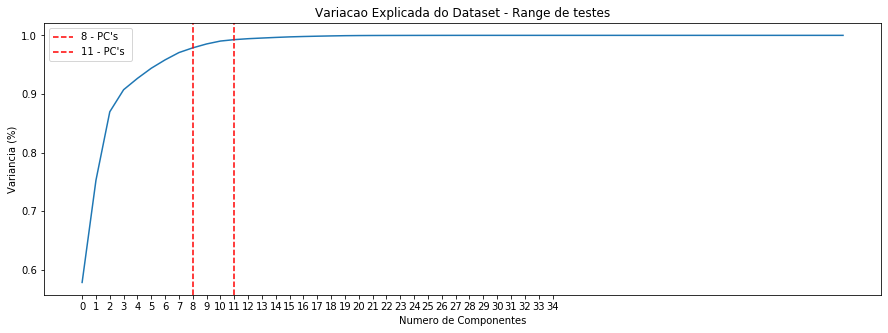

In [154]:
# Range de testes de Principal Componentes

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(variancia))
plt.xlabel('Numero de Componentes')
plt.ylabel('Variancia (%)') #for each component
plt.xticks(range(0,35))

plt.axvline(8, 0, 1, label='8 - PC\'s ',  color='r', linestyle='--')

plt.axvline(11, 0, 1, label='11 - PC\'s ',  color='r', linestyle='--')

plt.legend()
plt.title('Variacao Explicada do Dataset - Range de testes')

plt.show()

Podemos testar entre 8 e 11 componentes principais

# NÃO ESQUECER DE APLICAR O PCA NO DATASET DE TESTE 